In [1]:
%time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.legend_handler
import glob
import pysam
import collections
import os

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [165]:
%%time
#################################
#
#   Simplified plot of bh_p dependence on cells per cell-type
#
#################################
real_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*.csv')
real_df = pd.concat((pd.read_csv(p) for p in real_paths), ignore_index=True)
real_df['Status'] = 'Real'

perm_paths = glob.glob('../../nf_pipeline/outputs/sprawl_20220531_permuted/gene_ont/BICCN*.csv')
perm_df = pd.concat((pd.read_csv(p) for p in perm_paths), ignore_index=True)
perm_df['Status'] = 'Permuted'

vp_df = pd.concat((real_df,perm_df), ignore_index=True)

#rename metrics for nicer looking plots
vp_df['metric'] = vp_df['metric'].replace({
    'puncta':'Punctate',
    'central':'Central',
    'periph':'Peripheral',
    'radial':'Radial',
})
    
    
#Add binned cell count per gene/cell-type column
cell_count_bins = {
    'Exactly 20':(0,20), #Min number of cells is 20 
    'Between 21 and 50':(21,50),
    'Between 51 and 75':(51,75),
    'Between 76 and 150':(76,150),
    'Between 151 and 300':(151,300),
    'Between 301 and 500':(301,500)
}

for label,(low,high) in cell_count_bins.items(): 
    vp_df.loc[vp_df['num_cells'].between(low,high), 'Cells per gene/ont'] = label
    
    
#Add binned gene abundance column
vp_df['med_gene_frac'] = vp_df['med_gene_spots'].div(vp_df['med_spots'])

gene_abundance_bins = {
    'Fewer than 5':(0,0.005),
    'Between 5 and 10' :(0.005,0.010),
    'Between 10 and 20':(0.010,0.020),
    'Between 20 and 30':(0.020,0.030),
    'Between 30 and 40':(0.030,0.040),
    'More than 40':(0.040,1),
}

for label,(low,high) in gene_abundance_bins.items():
    vp_df.loc[vp_df['med_gene_frac'].between(low,high), 'Gene counts per 1000'] = label

    
def real_perm_metric_plots(
    vp_df, x, 
    hue, hue_order,
    x_label, y_label='Proportion of gene/cell-types',
    axvline=None, axhline=None,
    x_ticks=None, xlim=None
):
    """
    Helper function for plotting the metrics stratified by different columns
    """
    fig,axs = plt.subplots(
        nrows=1, ncols=4, figsize=(12,3),
        sharex=True, sharey=True
    )

    for (metric,g),ax in zip(vp_df.groupby('metric'),axs):
        show_legend = ax == axs[-1]

        sns.ecdfplot(
            data = g[g['Status'].eq('Permuted')],
            x = x,
            hue = hue,
            hue_order = hue_order,
            palette = 'Reds',
            legend = show_legend,
            ax = ax,
        )

        sns.ecdfplot(
            data = g[g['Status'].eq('Real')],
            x = x,
            hue = hue,
            hue_order = hue_order,
            palette = 'Blues',
            legend = show_legend,
            ax = ax,
        )

        if axvline != None:
            ax.axvline(axvline, linestyle='dashed', color='grey')
        if axhline != None:
            ax.axhline(axhline, linestyle='dashed', color='grey')
            
        ax.set_title(metric)

        if show_legend:
            sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))

        if x_ticks:
            ax.set_xticks(x_ticks)
        if xlim:
            ax.set_xlim(xlim[0],xlim[1])
            
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

    return fig,axs


CPU times: user 380 ms, sys: 7.8 ms, total: 388 ms
Wall time: 386 ms


([], [])


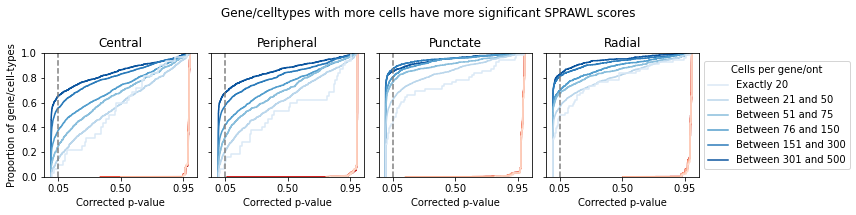

In [166]:
fig,axs = real_perm_metric_plots(
    vp_df,
    x = 'bh_p', 
    hue = 'Cells per gene/ont',
    hue_order = cell_count_bins.keys(),
    x_label = 'Corrected p-value',
    x_ticks = [0.05,0.5,0.95],
    axvline = 0.05,
)
plt.suptitle('Gene/celltypes with more cells have more significant SPRAWL scores')
plt.tight_layout()
plt.savefig('supplemental_figure_1_svgs/cell_count_effect.svg')
plt.show()
plt.close()

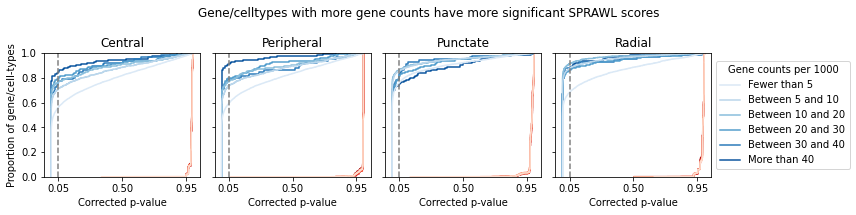

In [148]:
fig,axs = real_perm_metric_plots(
    vp_df, 
    x = 'bh_p',
    hue = 'Gene counts per 1000',
    hue_order = gene_abundance_bins.keys(),
    x_label = 'Corrected p-value',
    x_ticks = [0.05,0.5,0.95],
    axvline = 0.05,
)
plt.suptitle('Gene/celltypes with more gene counts have more significant SPRAWL scores')
plt.tight_layout()
plt.savefig('supplemental_figure_1_svgs/gene_abundance_effect.svg')
plt.show()
plt.close()

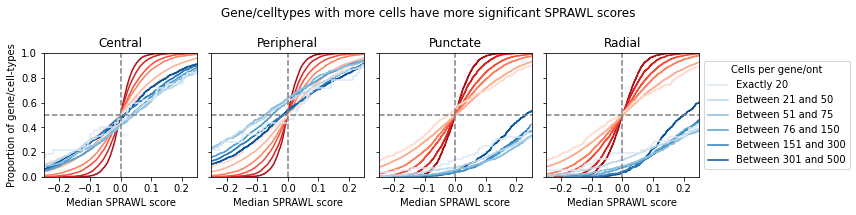

In [149]:
fig,axs = real_perm_metric_plots(
    vp_df, 
    x = 'med_score',
    hue = 'Cells per gene/ont',
    hue_order = cell_count_bins.keys(),
    x_label = 'Median SPRAWL score',
    xlim = (-0.25,0.25),
    axvline = 0.0, axhline = 0.5,
)
plt.suptitle('Gene/celltypes with more cells have more significant SPRAWL scores')
plt.tight_layout()
plt.savefig('supplemental_figure_1_svgs/cell_count_effect_med_score.svg')
plt.show()
plt.close()

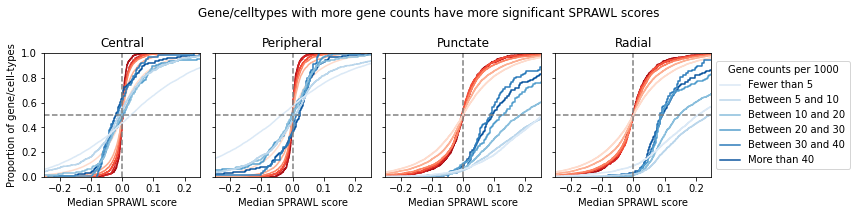

In [150]:
fig,axs = real_perm_metric_plots(
    vp_df, 
    x = 'med_score',
    hue = 'Gene counts per 1000',
    hue_order = gene_abundance_bins.keys(),
    x_label = 'Median SPRAWL score',
    xlim = (-0.25,0.25),
    axvline = 0.0, axhline = 0.5,
)
plt.suptitle('Gene/celltypes with more gene counts have more significant SPRAWL scores')
plt.tight_layout()
plt.savefig('supplemental_figure_1_svgs/gene_abundance_effect_med_score.svg')
plt.show()
plt.close()

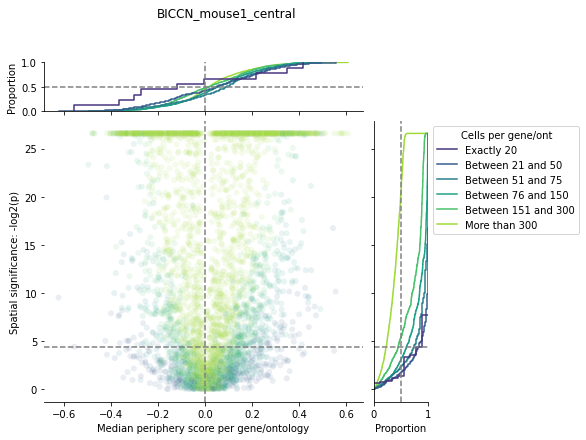

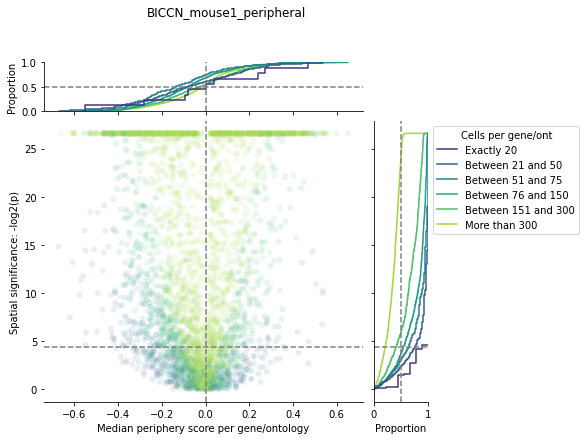

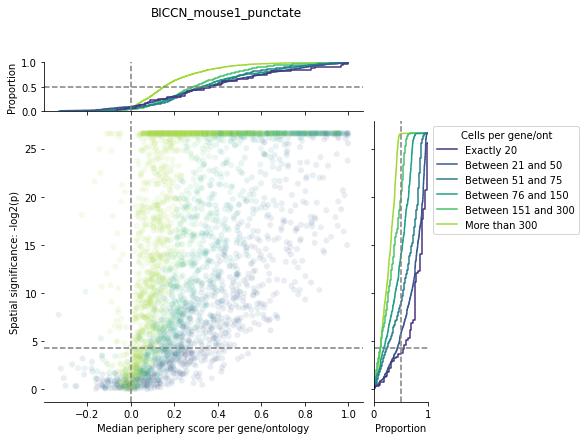

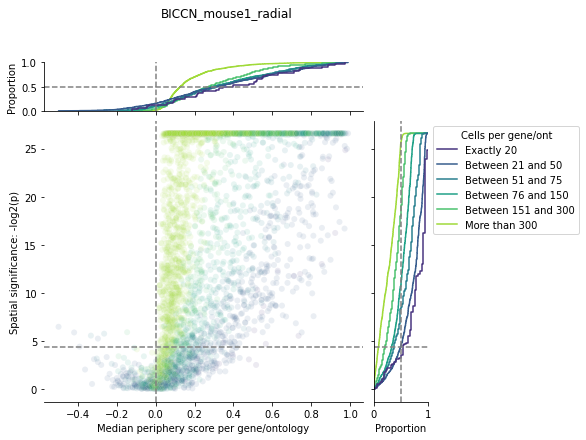

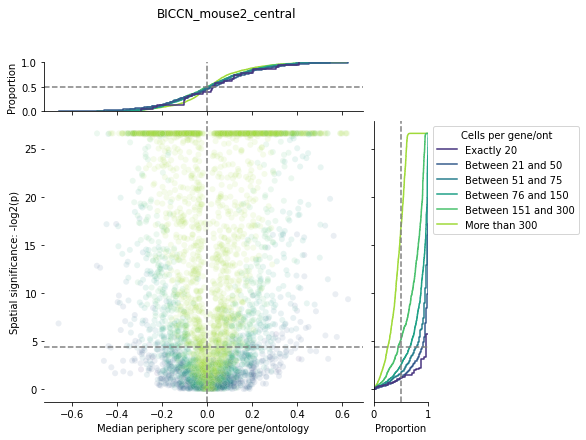

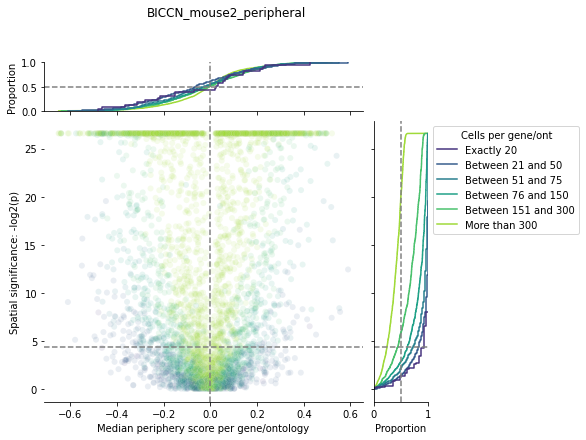

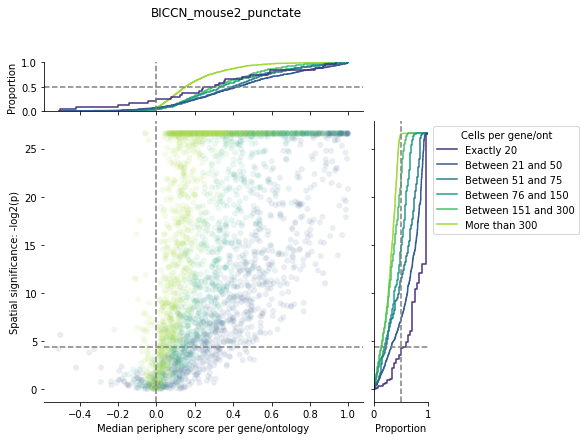

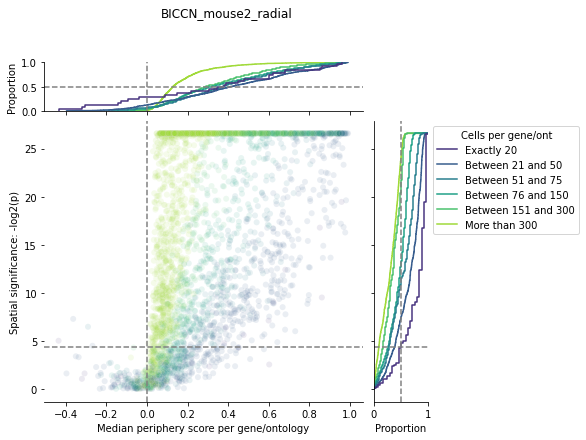

In [2]:
#################################
#
#   Effect on cells per ont on score and significance
#
#################################

gene_ont_samples = sorted(glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*.csv'))

for p in gene_ont_samples:
    name = os.path.basename(p).replace('_gene_ont.csv','')
    
    df = pd.read_csv(p)
    df['bh_p'] += 1e-8
    
    vp_df = df.copy()
    vp_df['Spatial significance: -log2(p)'] = -np.log2(vp_df['bh_p']) 

    vp_df.loc[vp_df['num_cells'] == 20, 'Cells per gene/ont'] = 'Exactly 20'
    vp_df.loc[vp_df['num_cells'].between(21,50), 'Cells per gene/ont'] = 'Between 21 and 50'
    vp_df.loc[vp_df['num_cells'].between(51,75), 'Cells per gene/ont'] = 'Between 51 and 75'
    vp_df.loc[vp_df['num_cells'].between(76,150), 'Cells per gene/ont'] = 'Between 76 and 150'
    vp_df.loc[vp_df['num_cells'].between(151,300), 'Cells per gene/ont'] = 'Between 151 and 300'
    vp_df['Cells per gene/ont'] = vp_df['Cells per gene/ont'].fillna('More than 300')

    hue_order = [
        'Exactly 20',
        'Between 21 and 50',
        'Between 51 and 75',
        'Between 76 and 150',
        'Between 151 and 300',
        'More than 300',
    ]


    g = sns.JointGrid(marginal_ticks=True)

    sns.scatterplot(
        x = 'med_score',
        y = 'Spatial significance: -log2(p)',
        hue = 'Cells per gene/ont',
        hue_order = hue_order,
        palette = 'viridis',
        alpha = 0.1,
        data = vp_df,
        legend = False,
        ax = g.ax_joint,
    )

    sns.ecdfplot(
        x = 'med_score',
        hue = 'Cells per gene/ont',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        legend = False,
        ax=g.ax_marg_x,
    )

    sns.ecdfplot(
        y = 'Spatial significance: -log2(p)',
        hue = 'Cells per gene/ont',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        #legend = False,
        ax=g.ax_marg_y,
    )

    #Show significance cutoff line -np.log2(0.05) ~= 4.32
    g.ax_joint.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axhline(4.32, linestyle = 'dashed', color = 'grey')

    #Vertical line at 0 median score
    g.ax_joint.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axvline(0, linestyle = 'dashed', color = 'grey')

    #Lines at 0.5 in the margins for the eCDFs
    g.ax_marg_x.axhline(0.5, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axvline(0.5, linestyle = 'dashed', color = 'grey')

    g.fig.suptitle(
        """{}
        """.format(name)
    )
    g.fig.subplots_adjust(top=0.85)
    g.ax_joint.set_xlabel('Median periphery score per gene/ontology')
    g.ax_joint.spines['left'].set_visible(False)

    #g.savefig('tpm_spatial_corrs/expressed_vs_unexpressed_peripheral_scoring_ecdf.svg')
    sns.move_legend(g.ax_marg_y, "upper left", bbox_to_anchor=(1, 1))
    plt.show(g)
    plt.close()
    

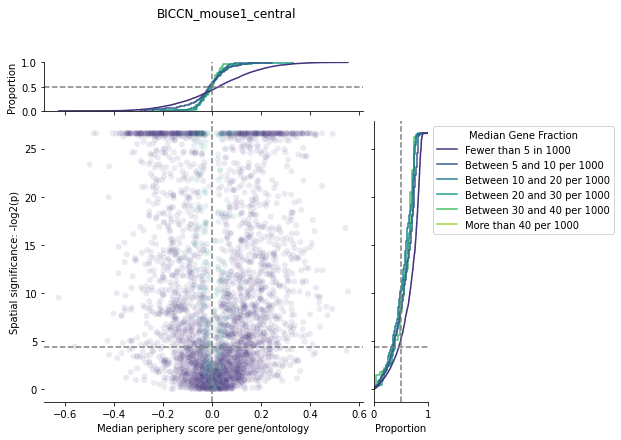

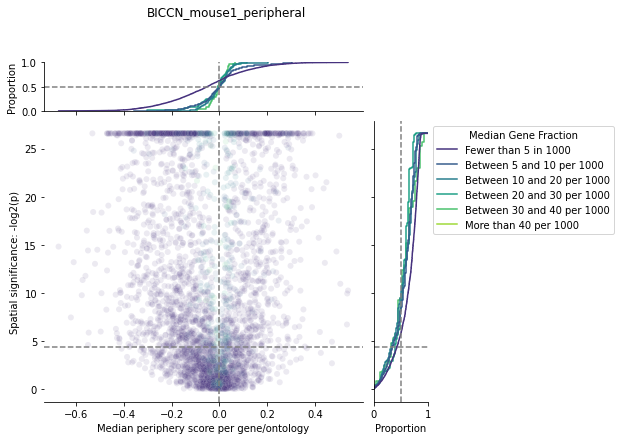

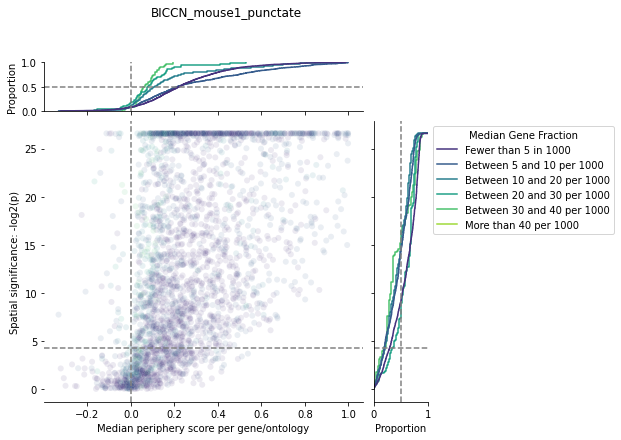

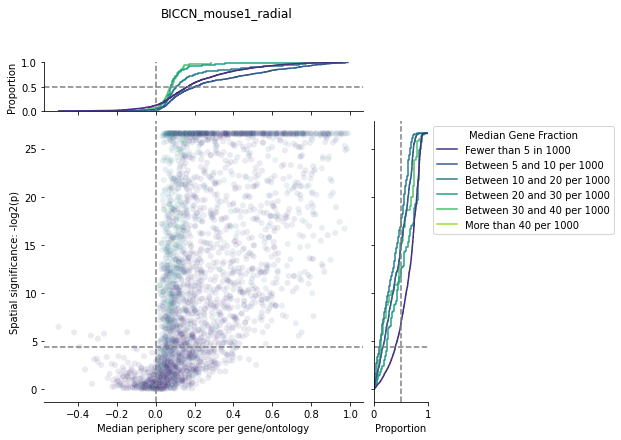

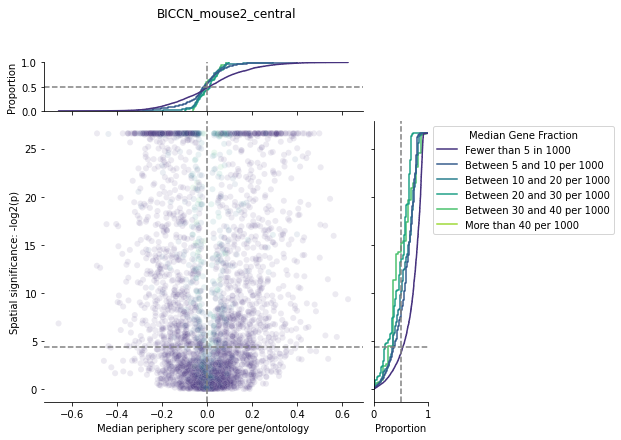

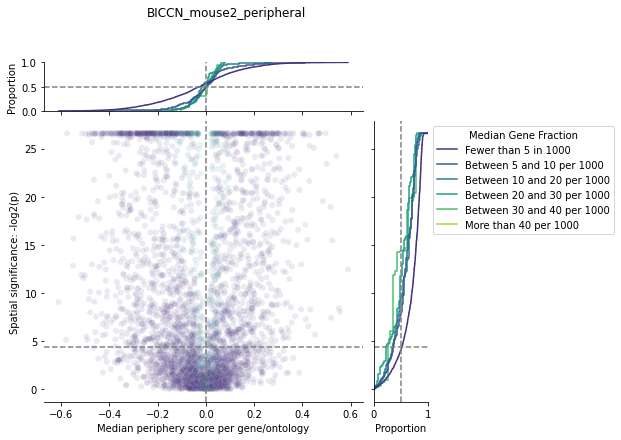

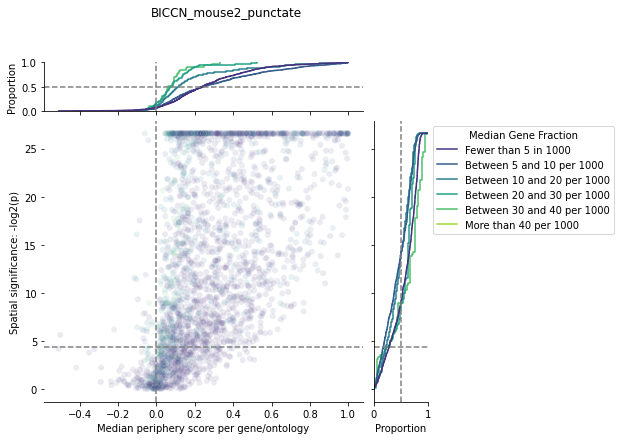

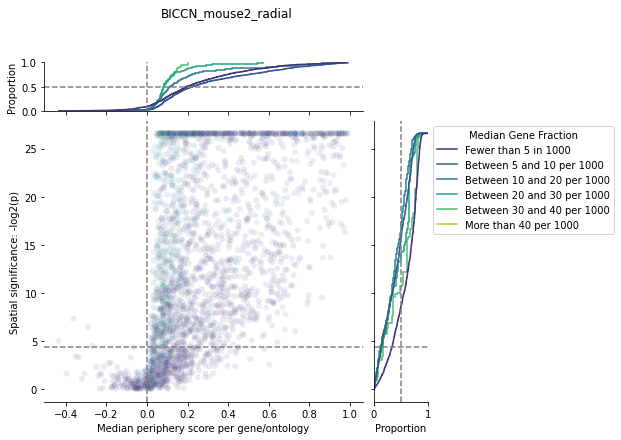

In [3]:
#################################
#
#   Effect on median gene/fraction per ont on score and significance
#
#################################

gene_ont_samples = sorted(glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*'))

for p in gene_ont_samples:
    df = pd.read_csv(p)
    df['bh_p'] += 1e-8
    
    name = os.path.basename(p).replace('_gene_ont.csv','')
    
    #avoiding -infs by filtering out gene/onts with pvals in the 10th quantile
    p_thresh = df['bh_p'].quantile(0.1)
    vp_df = df[df['bh_p'].gt(p_thresh)].copy()
    vp_df['Spatial significance: -log2(p)'] = -np.log2(vp_df['bh_p'])

    vp_df['med_gene_frac'] = vp_df['med_gene_spots'].div(vp_df['med_spots'])
    
    vp_df.loc[vp_df['med_gene_frac'] < 0.005, 'Median Gene Fraction'] = 'Fewer than 5 in 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.005,0.010), 'Median Gene Fraction'] = 'Between 5 and 10 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.010,0.020), 'Median Gene Fraction'] = 'Between 10 and 20 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.020,0.030), 'Median Gene Fraction'] = 'Between 20 and 30 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.030,0.040), 'Median Gene Fraction'] = 'Between 30 and 40 per 1000'
    vp_df['Cells per gene/ont'] = vp_df['Median Gene Fraction'].fillna('More than 40 per 1000')

    hue_order = [
        'Fewer than 5 in 1000',
        'Between 5 and 10 per 1000',
        'Between 10 and 20 per 1000',
        'Between 20 and 30 per 1000',
        'Between 30 and 40 per 1000',
        'More than 40 per 1000',
    ]


    g = sns.JointGrid(marginal_ticks=True)

    sns.scatterplot(
        x = 'med_score',
        y = 'Spatial significance: -log2(p)',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        alpha = 0.1,
        data = vp_df,
        legend = False,
        ax = g.ax_joint,
    )

    sns.ecdfplot(
        x = 'med_score',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        legend = False,
        ax=g.ax_marg_x,
    )

    sns.ecdfplot(
        y = 'Spatial significance: -log2(p)',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        #legend = False,
        ax=g.ax_marg_y,
    )

    #Show significance cutoff line -np.log2(0.05) ~= 4.32
    g.ax_joint.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axvline(0.5, linestyle = 'dashed', color = 'grey')

    #Vertical line at 0 median score
    g.ax_joint.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axhline(0.5, linestyle = 'dashed', color = 'grey')


    g.fig.suptitle(
        """{}
        """.format(name)
    )
    g.fig.subplots_adjust(top=0.85)
    g.ax_joint.set_xlabel('Median periphery score per gene/ontology')
    g.ax_joint.spines['left'].set_visible(False)

    #g.savefig('tpm_spatial_corrs/expressed_vs_unexpressed_peripheral_scoring_ecdf.svg')
    sns.move_legend(g.ax_marg_y, "upper left", bbox_to_anchor=(1, 1))
    plt.show(g)
    plt.close()
    
  

# Gene scRNAseq expression vs. metric

Analysis for BICCN data

Counting reads in each ontology for each gene from the 10Xv3 scRNAseq bam and then correlating read count to spatial median scores

In [ ]:
%%time
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'
bed_path = '../../preprocessing/BICCN_preprocessing/BICCN_merf_genes.bed'

bed_df = pd.read_csv(
    bed_path,
    header=None,
    names = ['chrom','start','end','gene','blank','strand'],
    sep=' ',
)

data = {}

with pysam.AlignmentFile(bam_path) as bam:
    for i,g in bed_df.iterrows():
        
        reads_per_ont = collections.Counter(
            r.get_tag('XO') for r in bam.fetch(g.chrom,g.start,g.end) 
            if (r.is_forward and g.strand == '+') | (r.is_reverse and g.strand == '-')
        )
        data[g.gene] = reads_per_ont
        
gene_read_counts = pd.DataFrame(data)

#convert to long form
gene_read_counts = gene_read_counts.reset_index().melt(id_vars='index',var_name='gene',value_name='counts')
gene_read_counts = gene_read_counts.rename(columns={'index':'annotation'})
gene_read_counts

In [ ]:
#distribution of read counts per gene/ontology
gene_read_counts['counts'].quantile(np.arange(0,1,0.1))

In [ ]:
#read in the median gene/annotation scores for each metric for both mice
#merge the read counts above
f_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*')
df = pd.concat(pd.read_csv(f_path) for f_path in f_paths)
df = df.merge(gene_read_counts).fillna(0)
df.head()

In [ ]:
%%time
#individaul gene plots of read count vs score for ontologies
import sprawl
from sprawl import plotting 

with plotting.make_pdf('read_count_vs_score.pdf') as pdf:

    for gene,plot_df in df.groupby('gene'):
        g = sns.catplot(
            x = 'counts',
            y = 'med_score',
            sharey = True, sharex = False,
            col = 'metric',
            col_wrap = 2,
            hue = 'experiment',
            data = plot_df,
        )
        plt.ylim([-1,1])
        g.map(plt.axhline, y=0, ls='--', c='grey')
        g.set_titles(gene+' {col_name}')
        pdf.savefig()
        #plt.show(g)
        plt.close()


# Permuted vs direct radial punctate score distributions

In [ ]:
samples = [
    'BICCN_mouse1_peripheral','BICCN_mouse1_central','BICCN_mouse1_radial','BICCN_mouse1_punctate',
    'BICCN_mouse2_peripheral','BICCN_mouse2_central','BICCN_mouse2_radial','BICCN_mouse2_punctate',
]

for sample in samples:
    perm_sample = glob.glob('../../nf_pipeline/outputs/sprawl_20220531_permuted/gene_ont/'+sample+'*')[0]
    dir_sample = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/'+sample+'*')[0]
    
    perm_df = pd.read_csv(perm_sample)
    perm_df['Permuted'] = True
    dir_df = pd.read_csv(dir_sample)
    dir_df['Permuted'] = False
    
    df = pd.concat((perm_df,dir_df),ignore_index=True)
    sns.ecdfplot(
        x = 'med_score',
        hue = 'Permuted',
        data = df,
    )
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axhline(0.5,linestyle='dashed',color='grey')
    plt.title(sample,fontsize=20)
    #plt.legend(fontsize=20)
    plt.xlabel('Median gene/cell-type score',fontsize=20)
    plt.ylabel('Proportion',fontsize=20)
    plt.show()
    plt.close()
    

In [ ]:
samples = [
    'vz_Brainmap_slice1_peripheral','vz_Brainmap_slice1_central','vz_Brainmap_slice1_radial','vz_Brainmap_slice1_punctate',
    'vz_Brainmap_slice2_peripheral','vz_Brainmap_slice2_central','vz_Brainmap_slice2_radial','vz_Brainmap_slice2_punctate',
    'vz_Brainmap_slice3_peripheral','vz_Brainmap_slice3_central','vz_Brainmap_slice3_radial','vz_Brainmap_slice3_punctate',
]

for sample in samples:
    perm_sample = glob.glob('../../nf_pipeline/outputs/sprawl_20220531_permuted/gene_ont/'+sample+'*')[0]
    dir_sample = glob.glob('../../nf_pipeline/outputs/vz_Brainmap_20220602_direct/gene_ont/'+sample+'*')[0]
    
    perm_df = pd.read_csv(perm_sample)
    perm_df['Permuted'] = True
    dir_df = pd.read_csv(dir_sample)
    dir_df['Permuted'] = False
    
    df = pd.concat((perm_df,dir_df),ignore_index=True)
    sns.ecdfplot(
        x = 'med_score',
        hue = 'Permuted',
        data = df,
    )
    plt.axvline(0,linestyle='dashed',color='grey')
    plt.axhline(0.5,linestyle='dashed',color='grey')
    plt.title(sample,fontsize=20)
    #plt.legend(fontsize=20)
    plt.xlabel('Median gene/cell-type score',fontsize=20)
    plt.ylabel('Proportion',fontsize=20)
    plt.show()
    plt.close()
    

# Individual cell plots to understand radial bias bettter

I'll look at a single sample and specific cells

In [ ]:
import sprawl
from sprawl import plotting, scoring

df = pd.read_csv('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/BICCN_mouse1_radial_gene_cell.csv')
sample = sprawl.HDF5('../../inputs/hdf5s/BICCN_mouse1sample1.hdf5')

df.head()

In [ ]:
df['num_gene_spots'].median()

In [ ]:
df[df['score'].gt(0.9)]['num_gene_spots'].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10])

In [ ]:
df[
    df['score'].lt(-0.9) &
    df['num_gene_spots'].eq(2)
]

In [ ]:
sub_df = df[
    df['score'].gt(0.9) &
    df['sample'].eq('m1s1')
].sort_values('num_gene_spots',ascending=True).head()
sub_df

for i,r in sub_df.iterrows():
    print(r['score'])
    cell = sample.get_cells_by_id([r['cell_id']])[0]
    plotting.plot_cell_zslices(cell, gene_colors={r['gene']:'red'})
    plt.show()
    plt.close()

# Understanding the punctate and radial non-symmetrical issue

In real data there is a strong bias to positive punctate and radial scores, but in the permuted gene-label datasets this trend is not observed.

I think the conclusion is that in real data, RNA molecules cluster with other RNA copies of the same gene more often than expected at random.


In [ ]:
#################################
#
#   Effect on median gene/fraction per ont on score and significance
#
#################################

gene_ont_samples = sorted(glob.glob('../../nf_pipeline/outputs/sprawl_20220531_permuted/gene_ont/*'))

for p in gene_ont_samples:
    df = pd.read_csv(p)
    df['bh_p'] += 1e-8
    
    name = os.path.basename(p).replace('_gene_ont.csv','')
    
    #avoiding -infs by filtering out gene/onts with pvals in the 10th quantile
    p_thresh = df['bh_p'].quantile(0.1)
    vp_df = df.copy()
    vp_df['Spatial significance: -log2(p)'] = -np.log2(vp_df['bh_p'])

    vp_df['med_gene_frac'] = vp_df['med_gene_spots'].div(vp_df['med_spots'])
    
    vp_df.loc[vp_df['med_gene_frac'] < 0.005, 'Median Gene Fraction'] = 'Fewer than 5 in 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.005,0.010), 'Median Gene Fraction'] = 'Between 5 and 10 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.010,0.020), 'Median Gene Fraction'] = 'Between 10 and 20 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.020,0.030), 'Median Gene Fraction'] = 'Between 20 and 30 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.030,0.040), 'Median Gene Fraction'] = 'Between 30 and 40 per 1000'
    vp_df['Cells per gene/ont'] = vp_df['Median Gene Fraction'].fillna('More than 40 per 1000')

    hue_order = [
        'Fewer than 5 in 1000',
        'Between 5 and 10 per 1000',
        'Between 10 and 20 per 1000',
        'Between 20 and 30 per 1000',
        'Between 30 and 40 per 1000',
        'More than 40 per 1000',
    ]


    g = sns.JointGrid(marginal_ticks=True)

    sns.scatterplot(
        x = 'med_score',
        y = 'Spatial significance: -log2(p)',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        alpha = 0.1,
        data = vp_df,
        legend = False,
        ax = g.ax_joint,
    )

    sns.ecdfplot(
        x = 'med_score',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        legend = False,
        ax=g.ax_marg_x,
    )

    sns.ecdfplot(
        y = 'Spatial significance: -log2(p)',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        #legend = False,
        ax=g.ax_marg_y,
    )

    #Show significance cutoff line -np.log2(0.05) ~= 4.32
    g.ax_joint.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axvline(0.5, linestyle = 'dashed', color = 'grey')

    #Vertical line at 0 median score
    g.ax_joint.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axhline(0.5, linestyle = 'dashed', color = 'grey')


    g.fig.suptitle(
        """{}
        """.format(name)
    )
    g.fig.subplots_adjust(top=0.85)
    g.ax_joint.set_xlabel('Median periphery score per gene/ontology')
    g.ax_joint.spines['left'].set_visible(False)

    #g.savefig('tpm_spatial_corrs/expressed_vs_unexpressed_peripheral_scoring_ecdf.svg')
    sns.move_legend(g.ax_marg_y, "upper left", bbox_to_anchor=(1, 1))
    plt.show(g)
    plt.close()
    
  

In [ ]:
#################################
#
#   Effect on cells per ont on score and significance
#
#################################

gene_ont_samples = sorted(glob.glob('../../nf_pipeline/outputs/sprawl_20220531_permuted/gene_ont/*.csv'))

for p in gene_ont_samples:
    name = os.path.basename(p).replace('_gene_ont.csv','')
    
    df = pd.read_csv(p)
    df['bh_p'] += 1e-8
    
    vp_df = df.copy()
    vp_df['Spatial significance: -log2(p)'] = -np.log2(vp_df['bh_p']) 

    vp_df.loc[vp_df['num_cells'] == 20, 'Cells per gene/ont'] = 'Exactly 20'
    vp_df.loc[vp_df['num_cells'].between(21,50), 'Cells per gene/ont'] = 'Between 21 and 50'
    vp_df.loc[vp_df['num_cells'].between(51,75), 'Cells per gene/ont'] = 'Between 51 and 75'
    vp_df.loc[vp_df['num_cells'].between(76,150), 'Cells per gene/ont'] = 'Between 76 and 150'
    vp_df.loc[vp_df['num_cells'].between(151,300), 'Cells per gene/ont'] = 'Between 151 and 300'
    vp_df['Cells per gene/ont'] = vp_df['Cells per gene/ont'].fillna('More than 300')

    hue_order = [
        'Exactly 20',
        'Between 21 and 50',
        'Between 51 and 75',
        'Between 76 and 150',
        'Between 151 and 300',
        'More than 300',
    ]


    g = sns.JointGrid(marginal_ticks=True)

    sns.scatterplot(
        x = 'med_score',
        y = 'Spatial significance: -log2(p)',
        hue = 'Cells per gene/ont',
        hue_order = hue_order,
        palette = 'viridis',
        alpha = 0.1,
        data = vp_df,
        legend = False,
        ax = g.ax_joint,
    )

    sns.ecdfplot(
        x = 'med_score',
        hue = 'Cells per gene/ont',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        legend = False,
        ax=g.ax_marg_x,
    )

    sns.ecdfplot(
        y = 'Spatial significance: -log2(p)',
        hue = 'Cells per gene/ont',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        #legend = False,
        ax=g.ax_marg_y,
    )

    #Show significance cutoff line -np.log2(0.05) ~= 4.32
    g.ax_joint.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axhline(4.32, linestyle = 'dashed', color = 'grey')

    #Vertical line at 0 median score
    g.ax_joint.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axvline(0, linestyle = 'dashed', color = 'grey')

    #Lines at 0.5 in the margins for the eCDFs
    g.ax_marg_x.axhline(0.5, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axvline(0.5, linestyle = 'dashed', color = 'grey')

    g.fig.suptitle(
        """{}
        """.format(name)
    )
    g.fig.subplots_adjust(top=0.85)
    g.ax_joint.set_xlabel('Median periphery score per gene/ontology')
    g.ax_joint.spines['left'].set_visible(False)

    #g.savefig('tpm_spatial_corrs/expressed_vs_unexpressed_peripheral_scoring_ecdf.svg')
    sns.move_legend(g.ax_marg_y, "upper left", bbox_to_anchor=(1, 1))
    plt.show(g)
    plt.close()
    

In [ ]:
#################################
#
#   Effect on median gene/fraction per ont on score and significance
#
#################################

gene_ont_samples = sorted(glob.glob('../../nf_pipeline/outputs/sprawl_20220531_permuted/gene_ont/*'))

for p in gene_ont_samples:
    df = pd.read_csv(p)
    df['bh_p'] += 1e-8
    
    name = os.path.basename(p).replace('_gene_ont.csv','')
    
    #avoiding -infs by filtering out gene/onts with pvals in the 10th quantile
    p_thresh = df['bh_p'].quantile(0.1)
    vp_df = df.copy()
    vp_df['Spatial significance: -log2(p)'] = -np.log2(vp_df['bh_p'])

    vp_df['med_gene_frac'] = vp_df['med_gene_spots'].div(vp_df['med_spots'])
    
    vp_df.loc[vp_df['med_gene_frac'] < 0.005, 'Median Gene Fraction'] = 'Fewer than 5 in 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.005,0.010), 'Median Gene Fraction'] = 'Between 5 and 10 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.010,0.020), 'Median Gene Fraction'] = 'Between 10 and 20 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.020,0.030), 'Median Gene Fraction'] = 'Between 20 and 30 per 1000'
    vp_df.loc[vp_df['med_gene_frac'].between(0.030,0.040), 'Median Gene Fraction'] = 'Between 30 and 40 per 1000'
    vp_df['Cells per gene/ont'] = vp_df['Median Gene Fraction'].fillna('More than 40 per 1000')

    hue_order = [
        'Fewer than 5 in 1000',
        'Between 5 and 10 per 1000',
        'Between 10 and 20 per 1000',
        'Between 20 and 30 per 1000',
        'Between 30 and 40 per 1000',
        'More than 40 per 1000',
    ]


    g = sns.JointGrid(marginal_ticks=True)

    sns.scatterplot(
        x = 'med_score',
        y = 'Spatial significance: -log2(p)',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        alpha = 0.1,
        data = vp_df,
        legend = False,
        ax = g.ax_joint,
    )

    sns.ecdfplot(
        x = 'med_score',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        legend = False,
        ax=g.ax_marg_x,
    )

    sns.ecdfplot(
        y = 'Spatial significance: -log2(p)',
        hue = 'Median Gene Fraction',
        hue_order = hue_order,
        palette = 'viridis',
        data = vp_df,
        #legend = False,
        ax=g.ax_marg_y,
    )

    #Show significance cutoff line -np.log2(0.05) ~= 4.32
    g.ax_joint.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axhline(4.32, linestyle = 'dashed', color = 'grey')
    g.ax_marg_y.axvline(0.5, linestyle = 'dashed', color = 'grey')

    #Vertical line at 0 median score
    g.ax_joint.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axvline(0, linestyle = 'dashed', color = 'grey')
    g.ax_marg_x.axhline(0.5, linestyle = 'dashed', color = 'grey')


    g.fig.suptitle(
        """{}
        """.format(name)
    )
    g.fig.subplots_adjust(top=0.85)
    g.ax_joint.set_xlabel('Median periphery score per gene/ontology')
    g.ax_joint.spines['left'].set_visible(False)

    #g.savefig('tpm_spatial_corrs/expressed_vs_unexpressed_peripheral_scoring_ecdf.svg')
    sns.move_legend(g.ax_marg_y, "upper left", bbox_to_anchor=(1, 1))
    plt.show(g)
    plt.close()
    
  